In [31]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)
library(math)
library(NatParksPalettes)

ERROR: Error in library(compositions): there is no package called ‘compositions’


# Read data

In [32]:
# Read the CSV file into a data frame
read_df <- read.csv('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Il1B_Cd14_mono_obsdata_certpro.csv')


In [33]:
getwd()

[1] "/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation"

In [34]:
read_df$facet <- paste(read_df$subject.biologicalSex, read_df$cohort.cohortGuid, sep = "_")

In [35]:
head(read_df)
colnames(read_df)
length(unique(read_df$subject.subjectGuid))
length(unique(read_df$specimen.specimenGuid))
dim(read_df)

,barcodes,original_barcodes,cell_name,batch_id,pool_id,chip_id,well_id,n_genes,n_reads,n_umis,⋯,sample.visitName,sample.drawDate,sample.subjectAgeAtDraw,specimen.specimenGuid,pipeline.fileGuid,leiden_resolution_0.5,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,facet
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
1,70ab258848b611eaa65d9e7d578d66f2,ATCACTTAGATACAGT,pine_enervated_caracal,B001,B001-P1,B001-P1C1,B001-P1C1W2,2354,27740,8105,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,1,7,Female_BR1
2,70acf29648b611eaa65d9e7d578d66f2,ATGCCTCGTTTGAACC,bland_sandy_owl,B001,B001-P1,B001-P1C1,B001-P1C1W2,4302,73872,21505,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,4,3,2,Female_BR1
3,70d2b34648b611eaa65d9e7d578d66f2,TCAGTTTAGCGCCTCA,mellow_intact_gecko,B001,B001-P1,B001-P1C1,B001-P1C1W2,2176,20037,6038,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,5,7,11,Female_BR1
4,a711a6d8489811ea92388a6a0c683ffb,AGACCATAGCGTCAAG,villainous_preoceanic_jackal,B001,B001-P1,B001-P1C1,B001-P1C1W3,1287,9010,2906,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,2,3,12,Female_BR1
5,a78438c4489811ea92388a6a0c683ffb,TTCCACGTCTTTCCGG,abdicable_centerable_gnu,B001,B001-P1,B001-P1C1,B001-P1C1W3,1051,6492,2278,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,14,14,Female_BR1
6,c688c40e48bd11eab2ee7a6edf799b61,ATTCACTAGGTAGACC,unsinkable_extendible_volvox,B001,B001-P1,B001-P1C1,B001-P1C1W4,1435,11925,3790,⋯,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,1,1,5,Female_BR1


[1] "barcodes"                "original_barcodes"      
 [3] "cell_name"               "batch_id"               
 [5] "pool_id"                 "chip_id"                
 [7] "well_id"                 "n_genes"                
 [9] "n_reads"                 "n_umis"                 
[11] "total_counts_mito"       "pct_counts_mito"        
[13] "doublet_score"           "predicted_AIFI_L1"      
[15] "AIFI_L1_score"           "AIFI_L1"                
[17] "predicted_AIFI_L2"       "AIFI_L2_score"          
[19] "AIFI_L2"                 "predicted_AIFI_L3"      
[21] "AIFI_L3_score"           "AIFI_L3"                
[23] "sample.sampleKitGuid"    "cohort.cohortGuid"      
[25] "subject.subjectGuid"     "subject.biologicalSex"  
[27] "subject.cmv"             "subject.bmi"            
[29] "subject.race"            "subject.ethnicity"      
[31] "subject.birthYear"       "subject.ageAtFirstDraw" 
[33] "sample.visitName"        "sample.drawDate"        
[35] "sample.subjectAgeAtDraw" "specimen.specimenGuid"  
[37] "pipeline.fileGuid"       "leiden_resolution_0.5"  
[39] "leiden_resolution_1"     "leiden_resolution_1.5"  
[41] "leiden_resolution_2"     "facet"

[1] 92

[1] 92

[1] 2835   42

# CLR Transform


In [36]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

# Comparsion within total PBMCs (Percentage and Percentage CLR)

In [37]:
#filter data for specific cluster

In [38]:
result <- read_df %>%
  dplyr::group_by(leiden_resolution_0.5, facet, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>% 
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>%
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

result

`summarise()` has grouped output by 'leiden_resolution_0.5', 'facet'. You can
override using the `.groups` argument.


leiden_resolution_0.5,facet,subject.subjectGuid,count,percentage,percentage_clr
<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
0,Female_BR1,BR1001,1,2.941176,-1.8296459
0,Female_BR1,BR1003,1,9.090909,-0.5991465
0,Female_BR1,BR1005,7,38.888889,0.6547137
0,Female_BR1,BR1008,3,50.000000,0.5013591
0,Female_BR1,BR1009,1,33.333333,-0.3465736
0,Female_BR1,BR1010,3,21.428571,0.3510784
0,Female_BR1,BR1013,2,28.571429,0.0000000
0,Female_BR1,BR1014,1,10.000000,-0.4969813
0,Female_BR1,BR1017,4,44.444444,0.3269431


# Plotting barplots per cluster

In [52]:
#subset dataframe by cluster
subset_df <- read_df %>% filter(read_df$leiden_resolution_0.5 == 3 )
dim(subset_df)

[1] 255  42

In [53]:
facet_count <- subset_df %>%
  dplyr::group_by(facet) %>%               
  dplyr::summarise(count = n()) %>%
  dplyr::mutate(percentage = (count / 2679) * 100) %>%   #<- change total cellcount
  dplyr::mutate(percentage_clr = clr_transform((percentage)))
  

facet_count

facet,count,percentage,percentage_clr
<chr>,<int>,<dbl>,<dbl>
Female_BR1,38,1.418440,-0.41746374
Female_BR2,117,4.367301,0.70712403
Male_BR1,47,1.754386,-0.20490230
Male_BR2,53,1.978350,-0.08475799


In [54]:
# install.packages("NatParksPalettes")
# library(NatParksPalettes)

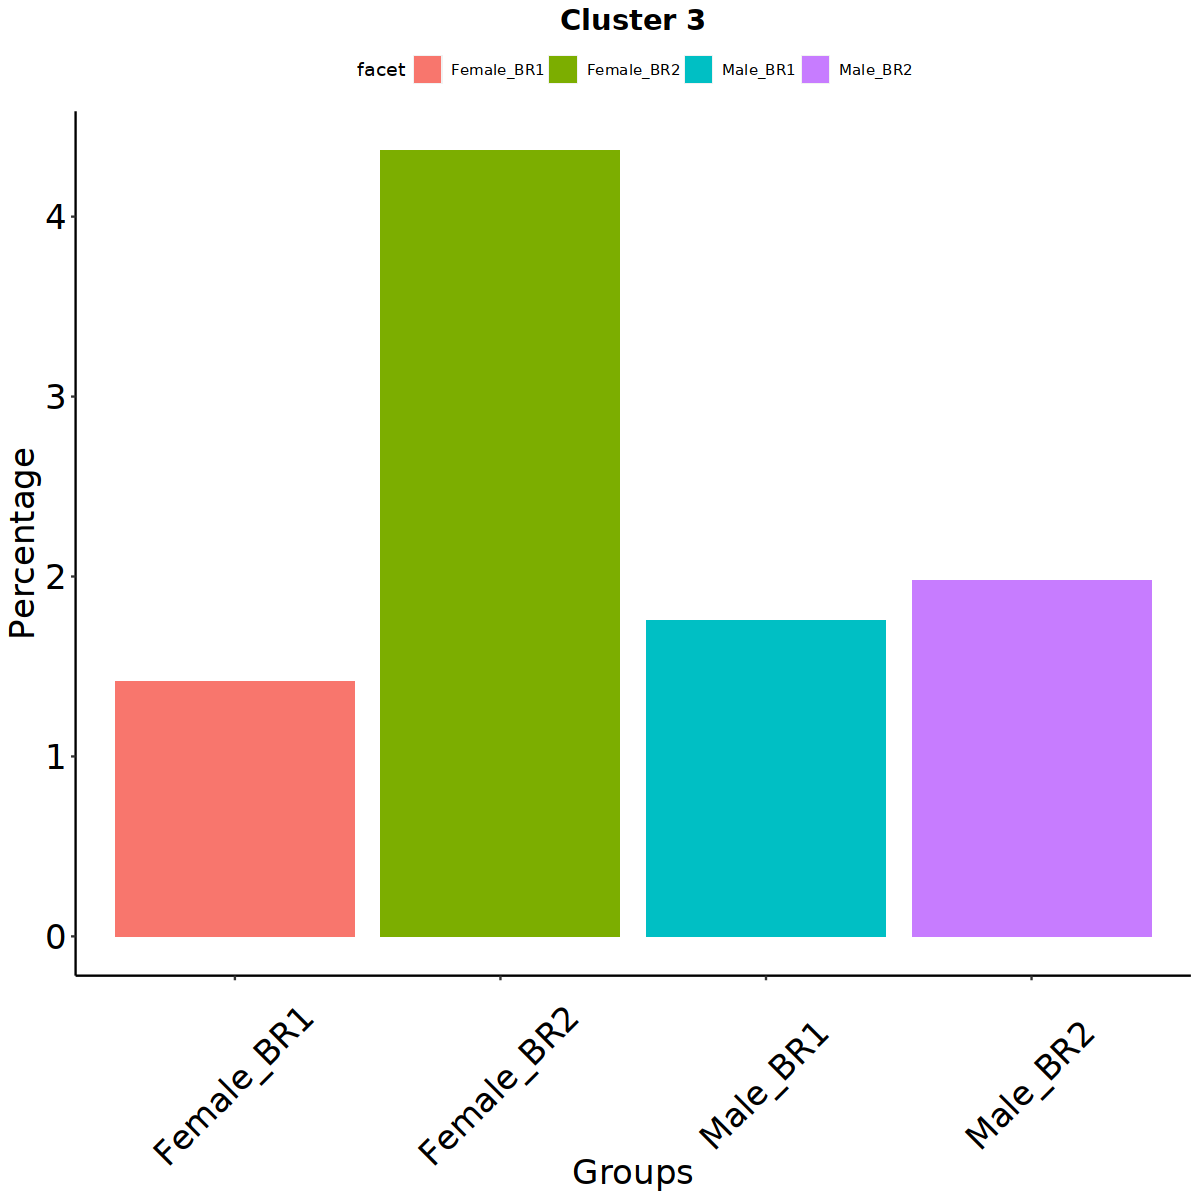

In [55]:

options(repr.plot.width = 10, repr.plot.height =10)
ggplot(facet_count, aes(x = facet , y = percentage, fill= facet)) +
  geom_col() +
  #scale_fill_manual(values=natparks.pals("SouthDowns", 4))+
  labs(#title = "Cluster 2",
       x = "Groups",
       y = "Percentage") +
  theme(axis.text.x = element_text(size = 20, angle = 45, vjust = 0.4, color= "black" ),     # Adjust font size of x-axis text
        axis.text.y = element_text(size = 20, color= "black"),     # Adjust font size of y-axis text
        axis.title = element_text(size = 20),
        panel.background = element_rect(fill = "white"),
        axis.line = element_line(color = "black"),  # Set axis line color to black,  # Set major grid line color to black
        panel.grid.minor = element_blank(),
        legend.position = "top",  # Set legend position to top
        #legend.title = element_blank()
       ) +
       ggtitle("Cluster 3") +
  theme(plot.title = element_text(hjust = 0.5, size = 17, face = "bold"))
   